### Paper 1
#### [Training Tips for the Transformer Model](https://arxiv.org/abs/1804.00247)

**Goals:**
 1. Learn how to improve Transformer importance without moving to another architecture
 2. Learn why certain techniques work well during training
 
*I will not be focusing on multi-GPU scaling.* Instead, this exercise is mostly for building a personal Transformer training framework.

### 1. Stopping Criterion

Takeaways:
 1. Stop training if after N evaluations, the improvement is smaller than delta
 2. Full learning curve visualizations help in assessing the general model training direction

#### 1.1 A stopping trainer
As noted in the paper, might lead to some premature judgements without a full learning curve

In [1]:
import time
import torch

# Reused from Paper 0
# With a halting condition added

class Trainer:

    def __init__(self, model, iterators, criterion, optimizer, device):

        train_iterator, valid_iterator, test_iterator = iterators

        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator
        self.test_iterator = test_iterator
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, eps=100, print_every=1, halting_N=4, halting_delta=1e-3, **kwargs):

        ts = []
        train_losses = []
        valid_losses = []
        stored = 0

        for e in range(eps):
                
            t, train_loss, valid_loss = self.train_evaluate_epoch()
            ts.append(t)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            stored += 1

            if stored == print_every or e + 1 == eps:
                self._print_sequence(ts[e - stored + 1:e + 1],
                                     train_losses[e - stored + 1:e + 1],
                                     valid_losses[e - stored + 1:e + 1],
                                     e - stored + 1, **kwargs)
                stored = 0
                
            # After computing, test halt condition
            if self.need_halt(valid_losses, halting_N, halting_delta):
                break

        test_loss = self.evaluate(self.test_iterator)
        self._print_last(ts, train_losses, valid_losses, test_loss, eps, **kwargs)
        
    def need_halt(self, valid_losses, halting_N, halting_delta):
        if len(valid_losses) >= halting_N:
            return valid_losses[-halting_N] - valid_losses[-1] < halting_delta
        else:
            return False

    def _print_sequence(self, ts, train_losses, valid_losses, epoch, **kwargs):

        sequence_time = sum(ts)
        minutes = int(sequence_time / 60)
        seconds = int(sequence_time % 60)

        if len(ts) > 1:
            epoch_string = f"Epochs {epoch}-{epoch + len(ts) - 1}"
        else:
            epoch_string = f"Epoch {epoch}"

        print(f'\n{epoch_string}: | Time: {minutes}m {seconds}s')
        print(f'Train loss: {train_losses[-1]}')
        print(f'Valid loss: {valid_losses[-1]}')

    def _print_last(self, ts, train_losses, valid_losses, test_loss, epoch, **kwargs):

        total_time = sum(ts)
        minutes = int(total_time / 60)
        seconds = int(total_time % 60)

        print(f'\nTotal Time: {minutes}m {seconds}s')
        print(f'Final test loss: {test_loss}')

    def train_evaluate_epoch(self):
        t1 = time.time()
        train_loss = self.train_epoch()
        valid_loss = self.evaluate(self.valid_iterator)
        t2 = time.time()
        t = t2 - t1
        return t, train_loss, valid_loss

    def train_epoch(self):
        self.model.train()
        total_loss = 0

        for i, batch in enumerate(self.train_iterator):
            self.optimizer.zero_grad()
            src, trg, out = self.forward(batch)
            loss = self.criterion(out, trg)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / len(self.train_iterator)
        return mean_loss

    def evaluate(self, iterator):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for i, batch in enumerate(iterator):
                src, trg, out = self.forward(batch)
                loss = self.criterion(out, trg)
                total_loss += loss.item()

        mean_loss = total_loss / len(iterator)
        return mean_loss

    def forward(self, batch, verbose=False):
        src = batch.src.to(self.device)  # [S, N]
        trg = batch.trg.to(self.device)  # [T + 1, N]

        if verbose:
            print(f'Data received from iterator: src=[{src.shape}]; trg=[{trg.shape}]')

        # Key moment: the -1 index omits the <eos> token
        # This is done because the decoder should never receive <eos> as input
        out = self.model(src, trg[:-1, :])  # [T, N, V]

        if verbose:
            print(f'Data received from model: out=[{out.shape}]')

        # Key moment: we cut off <sos> token from trg, because the model never learns to output it
        # This aligns the out and trg tokens for successful loss calculation
        out = out.reshape(-1, out.shape[2])  # [T * N, V]
        trg = trg[1:].reshape(-1)  # [T * N]

        if verbose:
            print(f'Data reshaped for loss computation: out=[{out.shape}]; trg=[{trg.shape}]')

        return src, trg, out

Test stopping trainer

In [2]:
from lib.transformers import *
from lib.datasets import *
from lib.evaluation import *

In [3]:
bs = 64
field_src, field_trg, src_vocab, trg_vocab, src_pad_idx, trg_pad_idx, sp_src, sp_trg, device, data, iterators = get_multi30k(bs)

In [4]:
model, optimizer, criterion = build_transformer(src_vocab, trg_vocab, src_pad_idx, trg_pad_idx, device)
trainer = Trainer(model, iterators, criterion, optimizer, device)

In [5]:
eps = 20
trainer.train(eps, 1)


Epoch 0: | Time: 1m 23s
Train loss: 6.016833213982603
Valid loss: 4.227247446775436

Epoch 1: | Time: 1m 21s
Train loss: 3.8371033621254473
Valid loss: 3.2015329152345657

Epoch 2: | Time: 1m 23s
Train loss: 3.0783009235029177
Valid loss: 2.6100951731204987

Epoch 3: | Time: 1m 24s
Train loss: 2.5415478577172705
Valid loss: 2.1989232674241066

Epoch 4: | Time: 1m 23s
Train loss: 2.1482001724222157
Valid loss: 1.900183066725731

Epoch 5: | Time: 1m 23s
Train loss: 1.9047001823454701
Valid loss: 1.7605540826916695

Epoch 6: | Time: 1m 24s
Train loss: 1.7612118912688437
Valid loss: 1.7187179177999496

Epoch 7: | Time: 1m 23s
Train loss: 1.6832277126249238
Valid loss: 1.7390082478523254

Epoch 8: | Time: 1m 23s
Train loss: 1.6616558700406079
Valid loss: 1.7125082314014435

Epoch 9: | Time: 1m 23s
Train loss: 1.602507315280679
Valid loss: 1.6506192088127136

Epoch 10: | Time: 1m 23s
Train loss: 1.5196560243152837
Valid loss: 1.5528361648321152

Epoch 11: | Time: 1m 24s
Train loss: 1.424663

In [6]:
translator = Translator(model, sp_src, field_src, field_trg, device)
translation = translator.translate("Three brothers are playing football")
print(translation)

['drei', 'welpen', 'spielen', 'football', ',', 'die', 'fußball', 'spielen', '.', '<eos>']


In [7]:
bleu = translator.calculate_bleu(data[2])
print(bleu)

29.219678044319153


#### 1.2 Learning curve visualization

As an alternative to TensorBoard monitoring, I'll use `matplotlib` for learning curve visualization.

Due to processing constraints on my machine, the following learning curves will be using Training / Validation loss instead of BLEU performance for each epoch.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(train_losses, valid_losses):
    
    plt.plot(np.arange(len(train_losses)), train_losses, color="#e44034", label="Train Loss")
    plt.plot(np.arange(len(valid_losses)), valid_losses, color="#7d9bda", label="Valid Loss")
    plt.legend()
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve")

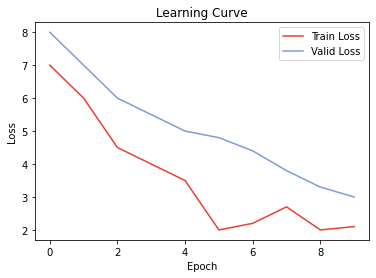

In [11]:
train_losses = [7, 6, 4.5, 4, 3.5, 2, 2.2, 2.7, 2, 2.1]
valid_losses = [8, 7, 6, 5.5, 5, 4.8, 4.4, 3.8, 3.3, 3]

plot_loss(train_losses, valid_losses)

### Summary

Some other takeaways (untested) from the paper:
 * Bigger models train better
 * Limiting sentence length hurts performance even if long sentences make up a small part of the dataset
 * Higher max-length may result in OOM (out-of-memory) errors
 * Higher batch size seems to help BLEU score